# Make your own surface data

CTSM needs lots of surface variables to run. 

CTSM technical notes has the official tutorial for creating surface datasets.

[**CTSM technical notes 1.3.5 Creating Surface data**](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/users_guide/using-clm-tools/creating-surface-datasets.html)

However, it is difficult to use the tool for users that are not familiar to CESM/CTSM. Because in pyclmuapp, we mainly focus on urban climate and the percentage of urban is set to 100%, which means the output are only urban related. Hence, we can easily over-write the urban surface data in the default `surfdata.nc` provided by pyclmuapp, this avoids the complex steps of using the mksurfdata_map tools.

---

**How to get our own urban surface data of the interest point from CESM provided file**

Ref: 
- [Technical Description of an Urban Parameterization for the Community Land Model (CLMU)](https://www.researchgate.net/publication/261062625_Technical_Description_of_an_Urban_Parameterization_for_the_Community_Land_Model_CLMU)

- [Table 3 Input data required for the urban model](https://www.researchgate.net/figure/3-Input-data-required-for-the-urban-model_tbl1_261062625)


Workflow
---

- get the urban surface input from [`mksrf_urban_0.05x0.05_simyr2000.c170724.nc`](https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/lnd/clm2/rawdata/)

- get the soil parameter for the pervious road in urban from [`mksrf_soitex.10level.c010119.nc`](https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/lnd/clm2/rawdata/)

- You **can directly** use the provided `surfdata.nc` by pyclmuapp, which is located at "pyclmuapp/usp/surfdata.nc". (No need to input)

In [1]:
%time
from pyclmuapp import get_urban_params
urban = get_urban_params(urban_ds='data/mksrf_urban_0.05x0.05_simyr2000.c170724.nc', # can be a xarray dataset or a path to a netcdf file
                 soil_ds='data/mksrf_soitex.10level.c010119.nc', # can be a xarray dataset or a path to a netcdf file
                 # here we use the default vancouverCAN dataset provided by CLM5.0 as template
                 lat = 51.5116,
                 lon = -0.1167,
                 #template='surfdata.nc', 
                 # optional, if not provided, the default surfdata dataset will be used
                 # the default surfdata dataset is the vancouverCAN dataset provided by CLM5.0 as follows
                 PTC_URBAN=[0,0,100.0], # percentage of urban land use in each density class, sum should be 100 
                 # this means that the urban land use is 100% in the MD class
                 outputname='data/surfdata_london.nc',)
urban # the created surfdata.nc file

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
No suitable point found in the search range, expanding search range.
Found suitable point at lat: 51.4116, lon: -0.1167
Found suitable point at lat: 51.4116, lon: -0.1167


<xarray.Dataset> Size: 9kB
Dimensions:                  (lsmlat: 1, lsmlon: 1, nlevsoi: 10, natpft: 15,
                              cft: 2, time: 12, lsmpft: 17, numurbl: 3,
                              numrad: 2, nglcecp1: 11, nglcec: 10, nlevurb: 10)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 8B 15 16
  * time                     (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * lsmlat                   (lsmlat) int32 4B 1
  * lsmlon                   (lsmlon) int32 4B 1
  * numrad                   (numrad) int32 8B 1 2
  * numurbl                  (numurbl) int32 12B 1 2 3
  * nlevurb                  (nlevurb) int32 40B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: nlevsoi, lsmpft, nglcecp1, nglcec
Data variables: (12/77)
    mxsoil_color             int32 4B ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 4B ...
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 80B 44.75 ... ...
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 80B 28.61 ... ...
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 80B ...
    FMAX                     (lsmlat, lsmlon) float64 8B ...
    ...                       ...
    TK_IMPROAD               (nlevurb, numurbl, lsmlat, lsmlon) float32 120B ...
    TK_ROOF                  (nlevurb, numurbl, lsmlat, lsmlon) float32 120B ...
    TK_WALL                  (nlevurb, numurbl, lsmlat, lsmlon) float32 120B ...
    CV_IMPROAD               (nlevurb, numurbl, lsmlat, lsmlon) float32 120B ...
    CV_ROOF                  (nlevurb, numurbl, lsmlat, lsmlon) float32 120B ...
    CV_WALL                  (nlevurb, numurbl, lsmlat, lsmlon) float32 120B ...
Attributes: (12/52)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:01
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    zero_out_pft_override:                TRUE
    history:                              Thu Feb 14 10:18:15 2019: ncks -A -...
    history_of_appended_files:            Thu Feb 14 10:18:15 2019: Appended ...
    NCO:                                  netCDF Operators version 4.7.4 (htt...

In [2]:
urban['URBAN_REGION_ID'].values, urban['LONGXY'].values, urban['LATIXY'].values

(array([[19]], dtype=int32), array([[359.875]]), array([[51.525]]))

### (optional) more to know about the urban parameters

**fist, let's check the mksrf_urban_0.05x0.05_simyr2000.c170724.nc**

In [3]:
from matplotlib import pyplot as plt
import xarray as xr

Region 0: 348 grid cells
Region 1: 74945 grid cells
Region 2: 278922 grid cells


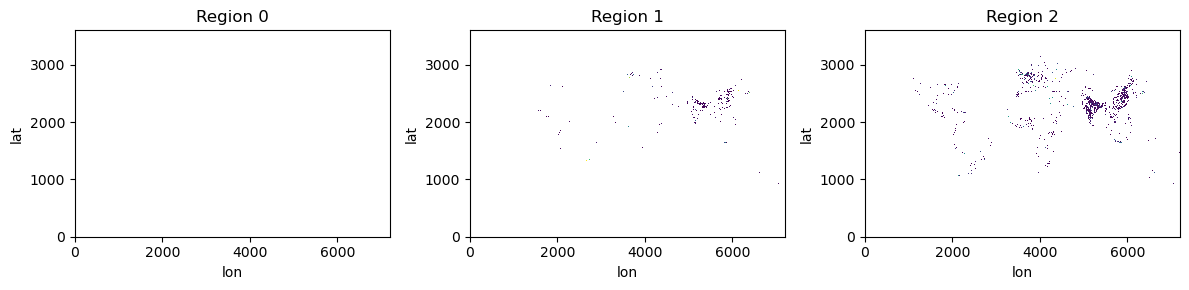

In [4]:
# open the downloaded mksrf_urban_0.05x0.05_simyr2000.c120621.nc
global_surf = xr.open_dataset('data/mksrf_urban_0.05x0.05_simyr2000.c120621.nc')
fig = plt.figure(figsize=(12, 3))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    global_surf['PCT_URBAN'].sel(density_class=i).where(global_surf['PCT_URBAN'].sel(density_class=i) > 0).plot(ax=ax, add_colorbar=False)
    print(f"Region {i}:", global_surf['PCT_URBAN'].sel(density_class=i).where(global_surf['PCT_URBAN'].sel(density_class=i) > 0).count().values, "grid cells")
    ax.set_title(f'Region {i}')
plt.tight_layout()
plt.show()

**then check mksrf_soitex.10level.c010119.nc**

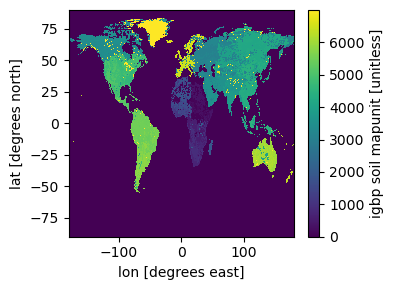

In [5]:
soil = xr.open_dataset('data/mksrf_soitex.10level.c010119.nc')
soil = soil.assign_coords(lat=soil.LAT, lon=soil.LON)   # add lat and lon as coordinates
fig = plt.figure(figsize=(4, 3))
soil['MAPUNITS'].plot()
plt.tight_layout()
plt.show()

### (Optional) here is the step for generate a template. 

This just helps you know how to generate a `surfdata.nc` template with 10 urban layers. 

Refer to [**Section: Create your urban parameters**](#create-your-urban-parameters) for creating your `surfdata.nc`.

Here we use the Vancouver city urban surface input file privdied by CTSM default case to generate the default surface data. 

We can aslo use the `surfdata.nc` provdied by pyclmuapp as template.


add the nevlurb to 10

In [6]:
ds_global = xr.open_dataset('data/mksrf_urban_0.05x0.05_simyr2000.c170724.nc')
ds_global = ds_global.assign_coords(lat=ds_global.LAT, lon=ds_global.LON)   # add lat and lon as coordinates
#ds_global.sel(lat=49.5, lon=236.5-360, method='nearest')['REGION_ID'].values  # 6
dd = ds_global.sel(lat=53.4808, lon=236.5-360, method='nearest')
dd = dd.sel(region=dd.REGION_ID.values-1)
dd

<xarray.Dataset> Size: 1kB
Dimensions:          (density_class: 3, numsolar: 2, numrad: 2, nlevurb: 10)
Coordinates:
    lat              float64 8B 53.47
    lon              float64 8B -123.5
Dimensions without coordinates: density_class, numsolar, numrad, nlevurb
Data variables: (12/31)
    LANDMASK         int8 1B ...
    LAT              float64 8B ...
    LON              float64 8B ...
    LATIXY           float64 8B ...
    LONGXY           float64 8B ...
    PCT_URBAN        (density_class) float64 24B ...
    ...               ...
    CV_IMPROAD       (nlevurb, density_class) float32 120B ...
    NLEV_IMPROAD     (density_class) float32 12B ...
    THICK_ROOF       (density_class) float32 12B ...
    THICK_WALL       (density_class) float32 12B ...
    T_BUILDING_MIN   (density_class) float32 12B ...
    T_BUILDING_MAX   (density_class) float32 12B ...
Attributes:
    date:     Mon Jul 24 10:08:51 MDT 2017
    source:   /glade/p/cgd/tss/people/oleson/urban_sfcdata/Feddema_urban_data...
    case_id:  Feddema/Jackson region_prop.170724-090103.csv (from urban prope...
    title:    Urban parameters for TBD,HD, and MD classes - Dominant - Lamina...

In [7]:
dd['LONGXY'].values, dd['LATIXY'].values, dd['REGION_ID'].values

(array(-123.475), array(53.475), array(6, dtype=int8))

In [8]:
import numpy as np
ds = xr.open_dataset('data/surfdata_1x1_vancouverCAN_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc')
for var in ['TK_IMPROAD', 'TK_ROOF', 'TK_WALL', 'CV_IMPROAD', 'CV_ROOF', 'CV_WALL']:
    del ds[var]
ds=ds.assign(nlevurb=(np.array(range(0, 10), dtype=np.int32)))
#ds['nlevurb'].values = np.array(range(1, 11), dtype=np.int32)
ds['LONGXY'].values, ds['LATIXY'].values
for var in ['TK_IMPROAD', 'TK_ROOF', 'TK_WALL', 'CV_IMPROAD', 'CV_ROOF', 'CV_WALL']:
    ds = ds.assign({var: (['nlevurb', 'numurbl', 'lsmlat', 'lsmlon'], dd[var].values.reshape(10, 3, 1, 1))})
    ds[var].attrs = dd[var].attrs
ds.to_netcdf('data/surfdata_1x1_vancouverCAN_hist_16pfts_Irrig_CMIP6_simyr2000_c190214_10levurb.nc')